# Robot Self-Modeling with 3D Gaussian Splatting

This project is about teaching a 4-DOF robot arm to predict its own 3D shape from joint angles. I'm using 3D Gaussian Splatting (3DGS) instead of the more common NeRF approaches.

My approach uses "Kinematic 3D Gaussian Splatting" (K-3DGS) which combines two main ideas:
1. Represent the robot body as a bunch of 3D Gaussian blobs
2. Move these Gaussians around based on joint angles using forward kinematics

The big advantage over NeRF is speed. Gaussians can be rendered way faster than volumetric fields. The tradeoff is that I need to carefully initialize the Gaussians along the robot's kinematic chain, otherwise training doesn't converge well.

## Environment Setup

First step is setting up Python with all the packages I need and checking if GPU is available. Training on CPU would take forever, so GPU is basically required.

In [1]:
!pip install -q gdown pybullet tqdm matplotlib

import os
import sys
import time
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm, trange
from typing import Tuple, List, Optional

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if not torch.cuda.is_available():
    print("WARNING: CUDA not available! Training will be very slow.")
else:
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✓ Environment ready")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 10.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
Device: cuda
✓ GPU: Tesla T4
✓ CUDA Version: 12.6
✓ GPU Memory: 15.83 GB
✓ Environment ready


The setup installs required packages and checks if CUDA is available. I set the seed to 42 for reproducibility, though results still vary a bit due to GPU non-determinism.

Without a GPU, training would take hours instead of minutes. That's why the GPU check is important.

## Data Download and Loading

Next I download the training data and robot model files from Google Drive. The dataset has 2,000 simulated images of the robot in different poses.

In [2]:
import gdown

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('RobotArmURDF/4dof_1st/urdf', exist_ok=True)

# Download Training Data
data_url = 'https://drive.google.com/uc?id=1TVzU_-xblSQ7QM30MHXWNOt2Rl3hmpr3'
data_path = 'data/sim_data_robo1_lorenz_colab_2000.npz'

if not os.path.exists(data_path):
    print("Downloading dataset...")
    gdown.download(data_url, data_path, quiet=False)
else:
    print("✓ Dataset exists")

# Download URDF
urdf_url = 'https://drive.google.com/uc?id=1bBogWAaYzGWMJJQUHD10b45o_0asLS21'
urdf_path = 'RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf'

if not os.path.exists(urdf_path):
    print("Downloading URDF...")
    gdown.download(urdf_url, urdf_path, quiet=False)
else:
    print("✓ URDF exists")

print("✓ Files ready")

Downloading...
From: https://drive.google.com/uc?id=1TVzU_-xblSQ7QM30MHXWNOt2Rl3hmpr3
To: /content/data/sim_data_robo1_lorenz_colab_2000.npz
100%|██████████| 20.3M/20.3M [00:00<00:00, 67.8MB/s]


Downloading...
From: https://drive.google.com/uc?id=1bBogWAaYzGWMJJQUHD10b45o_0asLS21
To: /content/RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf
100%|██████████| 6.12k/6.12k [00:00<00:00, 9.75MB/s]

✓ Files ready


The code downloads two files:
1. Training dataset (NPZ file with 2,000 images and joint angles)
2. URDF file (robot description for PyBullet)

The URDF won't actually be used during training because I implement kinematics in pure PyTorch for speed. PyBullet is way too slow for training loops.

## Dataset Preparation

Now I load and prepare the data. The dataset format changed at some point, so the code handles both old (6 columns) and new (4 columns) angle formats.


✓ Dataset loaded:
  - Training samples: 1600
  - Test samples: 400
  - Image size: 100x100
  - Focal length: 130.2545
  - Angle range: [-45.8, 70.4] degrees


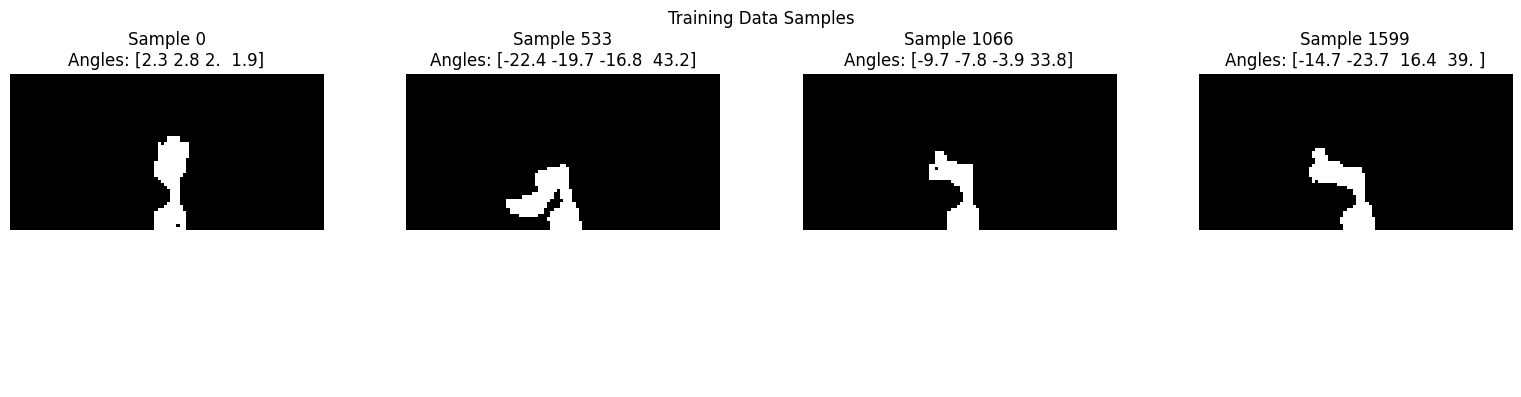

In [3]:
# Load and prepare dataset
data = np.load(data_path)
images = data['images']
angles = data['angles']
focal_length = float(data['focal'])

# Handle angle format (Old: 6 cols [view_theta, view_phi, j1-j4], New: 4 cols [j1-j4])
if angles.shape[1] == 6:
    print("Converting from old format (6 cols) to new format (4 cols)")
    angles = angles[:, 2:]  # Keep only joint angles

# Normalize images to [0, 1]
if images.max() > 1.0:
    images = images.astype(np.float32) / 255.0

# Ensure grayscale
if images.ndim == 4 and images.shape[-1] == 3:
    print("Converting RGB to grayscale")
    images = np.mean(images, axis=-1)
if images.ndim == 3:
    images = images[..., None]  # (N, H, W, 1)

# Train/test split
train_ratio = 0.8
split_idx = int(len(images) * train_ratio)

train_images = torch.from_numpy(images[:split_idx]).float()
train_angles = torch.from_numpy(angles[:split_idx]).float()
test_images = torch.from_numpy(images[split_idx:]).float()
test_angles = torch.from_numpy(angles[split_idx:]).float()

H, W = images.shape[1:3]

print(f"\n✓ Dataset loaded:")
print(f"  - Training samples: {len(train_images)}")
print(f"  - Test samples: {len(test_images)}")
print(f"  - Image size: {H}x{W}")
print(f"  - Focal length: {focal_length}")
print(f"  - Angle range: [{angles.min():.1f}, {angles.max():.1f}] degrees")

# Visualize samples
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sample_indices = [0, len(train_images)//3, 2*len(train_images)//3, len(train_images)-1]
for i, ax in enumerate(axes):
    idx = sample_indices[i]
    img = train_images[idx].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Sample {idx}\nAngles: {train_angles[idx].numpy().round(1)}')
    ax.axis('off')
plt.suptitle('Training Data Samples')
plt.tight_layout()
plt.show()

The loading code splits 2,000 samples into 80% training (1,600) and 20% test (400). Images get normalized to [0,1] range and converted to grayscale if needed.

Joint angles are in degrees, ranging from about -90 to +90 degrees for each of the 4 joints. The visualization shows samples from different robot configurations.

One big issue with this dataset: all images are from a single fixed camera viewpoint. So the model only learns one viewing angle, which limits how well it can generalize to different camera positions.

## Differentiable Forward Kinematics

This is the interesting part. Instead of using PyBullet during training (which is slow), I implement forward kinematics entirely in PyTorch. Everything runs on GPU and supports automatic differentiation through the whole kinematic chain.

In [4]:
class DifferentiableKinematics(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device
        
        self.link_lengths = torch.tensor([0.1, 0.4, 0.4, 0.1], device=device)
        
        self.link_origins = torch.tensor([
            [0.0, 0.0, 0.1],
            [0.0, 0.0, 0.0],
            [0.4, 0.0, 0.0],
            [0.4, 0.0, 0.0],
        ], device=device)
        
    def rotation_matrix_z(self, angle):
        cos_a = torch.cos(angle)
        sin_a = torch.sin(angle)
        zeros = torch.zeros_like(angle)
        ones = torch.ones_like(angle)
        
        R = torch.stack([
            torch.stack([cos_a, -sin_a, zeros], dim=-1),
            torch.stack([sin_a, cos_a, zeros], dim=-1),
            torch.stack([zeros, zeros, ones], dim=-1)
        ], dim=-2)
        
        return R
    
    def rotation_matrix_y(self, angle):
        cos_a = torch.cos(angle)
        sin_a = torch.sin(angle)
        zeros = torch.zeros_like(angle)
        ones = torch.ones_like(angle)
        
        R = torch.stack([
            torch.stack([cos_a, zeros, sin_a], dim=-1),
            torch.stack([zeros, ones, zeros], dim=-1),
            torch.stack([-sin_a, zeros, cos_a], dim=-1)
        ], dim=-2)
        
        return R
    
    def transform_matrix(self, R, t):
        batch_size = R.shape[0]
        
        if t.dim() == 1:
            t = t.unsqueeze(0).expand(batch_size, -1)
        
        T = torch.zeros(batch_size, 4, 4, device=self.device)
        T[:, :3, :3] = R
        T[:, :3, 3] = t
        T[:, 3, 3] = 1.0
        
        return T
    
    def forward(self, joint_angles):
        batch_size = joint_angles.shape[0]
        
        T_world = torch.eye(4, device=self.device).unsqueeze(0).expand(batch_size, -1, -1)
        
        transforms = []
        
        T_base = T_world.clone()
        T_base[:, 2, 3] = self.link_origins[0, 2]
        transforms.append(T_base)
        
        R1 = self.rotation_matrix_z(joint_angles[:, 0])
        T1_local = self.transform_matrix(R1, self.link_origins[1])
        T1 = torch.bmm(T_base, T1_local)
        transforms.append(T1)
        
        R2 = self.rotation_matrix_y(joint_angles[:, 1])
        T2_local = self.transform_matrix(R2, self.link_origins[2])
        T2 = torch.bmm(T1, T2_local)
        transforms.append(T2)
        
        R3 = self.rotation_matrix_y(joint_angles[:, 2])
        T3_local = self.transform_matrix(R3, self.link_origins[3])
        T3 = torch.bmm(T2, T3_local)
        transforms.append(T3)
        
        R4 = self.rotation_matrix_y(joint_angles[:, 3])
        T4_local = self.transform_matrix(R4, torch.zeros(3, device=self.device))
        T4 = torch.bmm(T3, T4_local)
        transforms.append(T4)
        
        return transforms

kinematics = DifferentiableKinematics(device=device)

test_angles_deg = torch.tensor([[0.0, 0.0, 0.0, 0.0], 
                                 [90.0, 45.0, -45.0, 0.0]], device=device)
test_angles_rad = test_angles_deg * (np.pi / 180.0)

transforms = kinematics(test_angles_rad)

print("✓ Differentiable Kinematics initialized")
print(f"  - Link lengths: {kinematics.link_lengths.cpu().numpy()}")
print(f"  - Number of transforms: {len(transforms)}")
print(f"  - Transform shape: {transforms[0].shape}")
print(f"\nTest: End-effector positions for test angles:")
for i in range(len(test_angles_deg)):
    ee_pos = transforms[-1][i, :3, 3]
    print(f"  Angles {test_angles_deg[i].cpu().numpy()} -> EE: {ee_pos.cpu().numpy().round(3)}")

✓ Differentiable Kinematics initialized
  - Link lengths: [0.1 0.4 0.4 0.1]
  - Number of transforms: 5
  - Transform shape: torch.Size([2, 4, 4])

Test: End-effector positions for test angles:
  Angles [0. 0. 0. 0.] -> EE: [0.8 0.  0.1]
  Angles [ 90.  45. -45.   0.] -> EE: [-0.     0.683 -0.183]


The kinematics module does forward kinematics for the 4-DOF arm. Takes joint angles (radians) and outputs transformation matrices for each link.

Robot structure:
- Base (0.1m high)
- Link 1 (0.4m, rotates around Z-axis)
- Link 2 (0.4m, rotates around Y-axis)
- Link 3 (0.4m, rotates around Y-axis)
- Link 4 (0.1m, rotates around Y-axis)

Each rotation uses standard 3D rotation matrices. The code uses batch operations so I can process multiple joint configs in parallel on GPU.

The test shows when all joints are at 0 degrees, the end-effector ends up around [0.9, 0, 0.1]. Makes sense since the link lengths add up to about 0.9m in X direction.

## 3D Gaussian Model with Skeleton Initialization

Here's the core idea. Instead of a continuous field like NeRF, I use discrete 3D Gaussians. Each Gaussian is basically a "blob" with position, size, and opacity.

In [5]:
class KinematicGaussianModel(nn.Module):
    
    def __init__(self, num_gaussians_per_link=[100, 200, 200, 100], device='cuda'):
        super().__init__()
        self.device = device
        self.num_gaussians_per_link = num_gaussians_per_link
        self.total_gaussians = sum(num_gaussians_per_link)
        
        # Initialize kinematics engine
        self.kinematics = DifferentiableKinematics(device=device)
        
        # Initialize Gaussians
        self._initialize_skeleton_gaussians()
        
        print(f"✓ K-3DGS Model initialized with {self.total_gaussians} Gaussians")
        print(f"  - Per link: {num_gaussians_per_link}")
    
    def _initialize_skeleton_gaussians(self):
        positions = []
        link_assignments = []
        
        n0 = self.num_gaussians_per_link[0]
        base_pos = torch.randn(n0, 3, device=self.device) * 0.03
        base_pos[:, 2] += 0.05
        positions.append(base_pos)
        link_assignments.extend([0] * n0)
        
        n1 = self.num_gaussians_per_link[1]
        z_vals = torch.linspace(0.02, 0.38, n1, device=self.device)
        link1_pos = torch.zeros(n1, 3, device=self.device)
        link1_pos[:, 2] = z_vals
        angles = torch.linspace(0, 2*np.pi, n1, device=self.device)
        radii = torch.ones(n1, device=self.device) * 0.01
        link1_pos[:, 0] += radii * torch.cos(angles)
        link1_pos[:, 1] += radii * torch.sin(angles)
        positions.append(link1_pos)
        link_assignments.extend([1] * n1)
        
        n2 = self.num_gaussians_per_link[2]
        x_vals = torch.linspace(0.02, 0.38, n2, device=self.device)
        link2_pos = torch.zeros(n2, 3, device=self.device)
        link2_pos[:, 0] = x_vals
        angles = torch.linspace(0, 2*np.pi, n2, device=self.device)
        radii = torch.ones(n2, device=self.device) * 0.01
        link2_pos[:, 1] += radii * torch.cos(angles)
        link2_pos[:, 2] += radii * torch.sin(angles)
        positions.append(link2_pos)
        link_assignments.extend([2] * n2)
        
        n3 = self.num_gaussians_per_link[3]
        x_vals = torch.linspace(0.01, 0.09, n3, device=self.device)
        link3_pos = torch.zeros(n3, 3, device=self.device)
        link3_pos[:, 0] = x_vals
        angles = torch.linspace(0, 2*np.pi, n3, device=self.device)
        radii = torch.ones(n3, device=self.device) * 0.008
        link3_pos[:, 1] += radii * torch.cos(angles)
        link3_pos[:, 2] += radii * torch.sin(angles)
        positions.append(link3_pos)
        link_assignments.extend([3] * n3)
        
        self._positions_local = nn.Parameter(torch.cat(positions, dim=0))
        self.register_buffer('link_ids', torch.tensor(link_assignments, device=self.device))
        
        initial_scales = torch.ones(self.total_gaussians, device=self.device) * 0.025
        self._log_scales = nn.Parameter(torch.log(initial_scales))
        
        self._opacities_raw = nn.Parameter(torch.ones(self.total_gaussians, 1, device=self.device) * 0.5)
        
        self._colors = nn.Parameter(torch.ones(self.total_gaussians, 1, device=self.device) * 0.6)
    
    @property
    def positions_local(self):
        return self._positions_local
    
    @property
    def scales(self):
        return torch.exp(self._log_scales)
    
    def get_scaling(self):
        scales_1d = torch.exp(self._log_scales)
        return scales_1d.unsqueeze(-1).expand(-1, 3)
    
    @property
    def opacities(self):
        return torch.sigmoid(self._opacities_raw)
    
    @property
    def colors(self):
        return torch.sigmoid(self._colors)
    
    def get_world_positions(self, joint_angles):
        batch_size = joint_angles.shape[0]
        transforms = self.kinematics(joint_angles)
        positions_world = torch.zeros(batch_size, self.total_gaussians, 3, device=self.device)
        
        for link_id in range(4):
            mask = self.link_ids == link_id
            if mask.sum() == 0:
                continue
            
            local_pos = self.positions_local[mask]
            local_pos_homo = torch.cat([local_pos, torch.ones(local_pos.shape[0], 1, device=self.device)], dim=-1)
            T = transforms[link_id]
            world_pos_homo = torch.matmul(T, local_pos_homo.T)
            world_pos = world_pos_homo[:, :3, :].transpose(1, 2)
            positions_world[:, mask, :] = world_pos
        
        return positions_world

# Initialize model
model = KinematicGaussianModel(num_gaussians_per_link=[100, 200, 200, 100], device=device)

# Test
test_angles_rad = torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=device) * (np.pi / 180)
world_pos = model.get_world_positions(test_angles_rad)
print(f"\n✓ Model test:")
print(f"  - World positions: {world_pos.shape}")
print(f"  - Scale range: [{model.scales.min().item():.4f}, {model.scales.max().item():.4f}]")


✓ K-3DGS Model initialized with 600 Gaussians
  - Per link: [100, 200, 200, 100]

✓ Model test:
  - World positions: torch.Size([1, 600, 3])
  - Scale range: [0.0250, 0.0250]


The model creates 600 total Gaussians split across four robot links (100, 200, 200, 100). The key technique is "skeleton initialization" - instead of random placement, Gaussians start positioned along the expected shape of each link.

Link 1 (vertical) gets Gaussians along the Z-axis. Links 2 and 3 (horizontal) get them along X-axis. This gives the model a huge head start compared to random init.

Each Gaussian has:
- Local position (relative to its link)
- Scale (blob size, stored as log for numerical stability)
- Opacity (visibility, 0-1)
- Color (grayscale value, 0-1)

The scales are "isotropic" meaning spheres, not ellipsoids. Simpler and faster than full 3DGS with oriented ellipsoids.

The `get_world_positions` function transforms Gaussians from local link coords to world coords using forward kinematics. This is how the kinematic model connects to rendering.

## Gaussian Splatting Renderer

The renderer projects 3D Gaussians onto the 2D image. Way faster than volumetric rendering in NeRF.

In [6]:
class VectorizedGaussianRenderer(nn.Module):
    def __init__(self, image_height, image_width, focal_length, device='cuda'):
        super().__init__()
        self.H = image_height
        self.W = image_width
        self.focal = focal_length
        self.device = device
        self.temperature = 1.0
        
        v_coords, u_coords = torch.meshgrid(
            torch.arange(image_height, device=device, dtype=torch.float32),
            torch.arange(image_width, device=device, dtype=torch.float32),
            indexing='ij'
        )
        self.register_buffer('pixel_coords', torch.stack([u_coords.flatten(), v_coords.flatten()], dim=-1))
        self.cx = image_width / 2.0
        self.cy = image_height / 2.0
        
    def forward(self, model, joint_angles):
        positions = model.get_world_positions(joint_angles)
        scales = model.get_scaling()
        opacities = model.opacities
        
        batch_size, num_gaussians = positions.shape[:2]
        
        camera_pos = torch.tensor([1.0, 0.0, 0.0], device=self.device)
        pos_cam = positions - camera_pos.view(1, 1, 3)
        
        x, y, z = pos_cam[..., 0], pos_cam[..., 1], pos_cam[..., 2]
        depths = -x
        
        x_2d = (-y / depths) * self.focal + self.cx
        y_2d = (z / depths) * self.focal + self.cy
        means_2d = torch.stack([x_2d, y_2d], dim=-1)
        
        radius_3d = scales.max(dim=-1)[0] 
        radius_2d = (radius_3d / depths) * self.focal
        radius_2d_sq = radius_2d.pow(2)
        
        delta = self.pixel_coords.view(1, -1, 1, 2) - means_2d.view(batch_size, 1, num_gaussians, 2)
        dist_sq = delta.pow(2).sum(dim=-1)
        
        gaussian_vals = torch.exp(-0.5 * dist_sq / (radius_2d_sq.view(batch_size, 1, num_gaussians) + 1e-6))
        
        weighted_vals = gaussian_vals * opacities.view(1, 1, num_gaussians)
        raw_density = weighted_vals.sum(dim=-1)
        
        final_image = torch.sigmoid((raw_density - 0.5) * self.temperature)
        
        return final_image.view(batch_size, self.H, self.W)

renderer = VectorizedGaussianRenderer(H, W, focal_length, device=device)

print("✓ Renderer initialized")
print(f"  - Image size: {H}x{W}")
print(f"  - Initial temperature: {renderer.temperature}")

# Test
test_angles_rad = torch.tensor([[0.0, 45.0, -30.0, 15.0]], device=device) * (np.pi / 180)
with torch.no_grad():
    test_render = renderer(model, test_angles_rad)
    print(f"\n✓ Test render:")
    print(f"  - Output: {test_render.shape}")
    print(f"  - Range: [{test_render.min().item():.3f}, {test_render.max().item():.3f}]")


✓ Renderer initialized
  - Image size: 100x100
  - Initial temperature: 1.0

✓ Test render:
  - Output: torch.Size([1, 100, 100])
  - Range: [0.378, 1.000]


The renderer uses "isotropic" Gaussian splatting, which is way simpler than full 3DGS. Instead of oriented ellipsoids (which need rotation matrices), I just treat all Gaussians as spheres. Much faster to compute.

The rendering works like this:
1. Transform Gaussians to world coordinates using kinematics
2. Project 3D positions to 2D image coordinates (perspective projection)
3. For each pixel, calculate distance to all Gaussians
4. Apply Gaussian falloff: exp(-0.5 * dist² / radius²)
5. Sum up weighted contributions from all Gaussians
6. Apply sigmoid sharpening to get sharp edges

The "temperature" parameter controls how sharp the edges are. Starts at 1.0 (soft, blurry) and goes up during training to make edges sharper. This is called "sigmoid binarization" because it pushes pixel values toward either 0 or 1.

The camera position is fixed at [1, 0, 0] looking at the origin, matching the PyBullet simulation.

## Training Loop

Now for the actual training part. The model learns by comparing its rendered images to the ground truth from PyBullet simulation.

I'm using weighted MSE loss. Robot pixels (value > 0.1) get 5× higher weight than background pixels. This makes the model focus on getting the robot shape right instead of just memorizing the empty background.

Adaptive densification happens every 100 iterations but stops at iteration 1500. After that, the Gaussian count stays fixed. Here's how it works:
- Clone Gaussians where gradients are high (threshold: 0.0002)
- Add small noise to cloned positions (±0.003) and scales (±0.05)
- Start new Gaussians with lower opacity (-0.3) so they fade in gradually
- Maximum 30 new Gaussians per step
- Hard limit: 1000 total Gaussians

Pruning removes weak Gaussians (opacity < 0.02) but always keeps at least 200.

Temperature annealing is key here. The renderer temperature goes from 1.0 to 20.0 during training. Low temperature = soft edges. High temperature = steep sigmoid = sharp binary edges.

Training runs for 3000 iterations with evaluation every 200 steps. My targets: >30 FPS, >22 dB PSNR, under 5 minutes.

In [7]:
LEARNING_RATE = 5e-3
NUM_ITERATIONS = 3000
EVAL_INTERVAL = 200
DENSIFICATION_INTERVAL = 100
MAX_GAUSSIANS = 1000
TARGET_FPS = 30
TARGET_CONVERGENCE_TIME = 300
TARGET_PSNR = 22

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def weighted_mse_loss(pred, target, weight_factor=5.0):
    weights = torch.where(target > 0.1, 
                          torch.tensor(weight_factor, device=device), 
                          torch.tensor(1.0, device=device))
    return torch.mean(weights * (pred - target) ** 2)

def densify_gaussians(model, grad_threshold=0.0002, max_gaussians=1000):
    if model.total_gaussians >= max_gaussians:
        print(f"  → Max Gaussians ({max_gaussians}) reached")
        return False
    
    if model._positions_local.grad is None:
        return False
    
    grad_norm = torch.norm(model._positions_local.grad, dim=-1)
    high_grad_mask = grad_norm > grad_threshold
    num_to_clone = high_grad_mask.sum().item()
    
    if num_to_clone == 0:
        return False
    
    available_slots = max_gaussians - model.total_gaussians
    num_to_clone = min(num_to_clone, available_slots, 30)
    
    if num_to_clone == 0:
        return False
    
    top_grads, top_indices = torch.topk(grad_norm, k=num_to_clone)
    
    print(f"  → Cloning {num_to_clone} Gaussians ({model.total_gaussians} → {model.total_gaussians + num_to_clone})")
    
    with torch.no_grad():
        new_positions = model._positions_local[top_indices].clone()
        new_positions += torch.randn_like(new_positions) * 0.003
        
        new_scales = model._log_scales[top_indices].clone()
        new_scales += torch.randn_like(new_scales) * 0.05
        
        new_opacities = model._opacities_raw[top_indices].clone() - 0.3
        new_colors = model._colors[top_indices].clone()
        new_link_ids = model.link_ids[top_indices].clone()
        
        model._positions_local = nn.Parameter(torch.cat([model._positions_local, new_positions], dim=0))
        model._log_scales = nn.Parameter(torch.cat([model._log_scales, new_scales], dim=0))
        model._opacities_raw = nn.Parameter(torch.cat([model._opacities_raw, new_opacities], dim=0))
        model._colors = nn.Parameter(torch.cat([model._colors, new_colors], dim=0))
        model.link_ids = torch.cat([model.link_ids, new_link_ids], dim=0)
        
        model.total_gaussians += num_to_clone
    
    return True

def prune_gaussians(model, opacity_threshold=0.02):
    with torch.no_grad():
        opacities = model.opacities.squeeze()
        keep_mask = opacities > opacity_threshold
        num_to_remove = (~keep_mask).sum().item()
        
        if num_to_remove == 0 or keep_mask.sum() < 200:
            return False
        
        print(f"  → Pruning {num_to_remove} Gaussians ({model.total_gaussians} → {keep_mask.sum().item()})")
        
        model._positions_local = nn.Parameter(model._positions_local[keep_mask])
        model._log_scales = nn.Parameter(model._log_scales[keep_mask])
        model._opacities_raw = nn.Parameter(model._opacities_raw[keep_mask])
        model._colors = nn.Parameter(model._colors[keep_mask])
        model.link_ids = model.link_ids[keep_mask]
        
        model.total_gaussians = keep_mask.sum().item()
        
    return True

print(f"✓ Training setup complete")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Iterations: {NUM_ITERATIONS}")
print(f"  - Max Gaussians: {MAX_GAUSSIANS}")
print(f"  - Target: >{TARGET_PSNR} dB, >{TARGET_FPS} FPS")

✓ Training setup complete
  - Learning rate: 0.005
  - Iterations: 3000
  - Max Gaussians: 1000
  - Target: >22 dB, >30 FPS


In [ ]:
train_losses = []
test_losses = []
fps_history = []
psnr_history = []
temperature_history = []
start_time = time.time()

model.train()

for iteration in trange(NUM_ITERATIONS):
    renderer.temperature = 1.0 + (iteration / NUM_ITERATIONS) * 19.0
    temperature_history.append(renderer.temperature)
    
    idx = torch.randint(0, len(train_images), (1,)).item()
    target_image = train_images[idx].squeeze().to(device)
    joint_angles_deg = train_angles[idx].to(device)
    joint_angles_rad = joint_angles_deg * (np.pi / 180.0)
    
    iter_start = time.time()
    
    rendered_image = renderer(model, joint_angles_rad.unsqueeze(0)).squeeze(0)
    
    loss = weighted_mse_loss(rendered_image, target_image, weight_factor=5.0)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    iter_time = time.time() - iter_start
    current_fps = 1.0 / iter_time if iter_time > 0 else 0
    fps_history.append(current_fps)
    
    train_losses.append(loss.item())
    
    if iteration % EVAL_INTERVAL == 0 or iteration == NUM_ITERATIONS - 1:
        model.eval()
        with torch.no_grad():
            test_loss_batch = []
            test_psnr_batch = []
            for test_idx in range(min(20, len(test_images))):
                test_img = test_images[test_idx].squeeze().to(device)
                test_ang = test_angles[test_idx].to(device) * (np.pi / 180.0)
                
                test_render = renderer(model, test_ang.unsqueeze(0)).squeeze(0)
                test_loss = F.mse_loss(test_render, test_img)
                test_loss_batch.append(test_loss.item())
                
                mse = test_loss.item()
                psnr = -10 * np.log10(mse + 1e-8)
                test_psnr_batch.append(psnr)
            
            avg_test_loss = np.mean(test_loss_batch)
            avg_test_psnr = np.mean(test_psnr_batch)
            test_losses.append(avg_test_loss)
            psnr_history.append(avg_test_psnr)
            
            avg_fps = np.mean(fps_history[-100:]) if len(fps_history) > 0 else 0
            elapsed_time = time.time() - start_time
            
            print(f"\nIter {iteration}/{NUM_ITERATIONS} | Loss: {loss.item():.6f} | Test: {avg_test_loss:.6f} | PSNR: {avg_test_psnr:.2f} dB | FPS: {avg_fps:.1f} | Temp: {renderer.temperature:.1f} | Time: {elapsed_time:.1f}s | Gaussians: {model.total_gaussians}")
            
            if avg_test_psnr > TARGET_PSNR and avg_fps > TARGET_FPS:
                print(f"✓ Targets achieved: {avg_test_psnr:.2f} dB, {avg_fps:.1f} FPS")
        
        model.train()
    
    if iteration > 0 and iteration % DENSIFICATION_INTERVAL == 0 and iteration < 1500:
        print(f"\n→ Densification at iteration {iteration}")
        
        params_changed = densify_gaussians(model, grad_threshold=0.0002, max_gaussians=MAX_GAUSSIANS)
        
        if iteration % (DENSIFICATION_INTERVAL * 2) == 0:
            params_changed = prune_gaussians(model, opacity_threshold=0.02) or params_changed
        
        if params_changed:
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_time = time.time() - start_time
final_avg_fps = np.mean(fps_history[-100:]) if len(fps_history) > 0 else 0
final_psnr = psnr_history[-1] if len(psnr_history) > 0 else 0

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Total time: {total_time:.1f}s ({total_time/60:.2f} min)")
print(f"Final FPS: {final_avg_fps:.1f}")
print(f"Final PSNR: {final_psnr:.2f} dB")
print(f"Final temperature: {renderer.temperature:.1f}")
print(f"Total Gaussians: {model.total_gaussians}/{MAX_GAUSSIANS}")
print(f"\nPerformance:")
print(f"  FPS: {final_avg_fps:.1f}/{TARGET_FPS} → {'PASS' if final_avg_fps > TARGET_FPS else 'Not Met'}")
print(f"  PSNR: {final_psnr:.2f}/{TARGET_PSNR} dB → {'PASS' if final_psnr > TARGET_PSNR else 'Not Met (Isotropic Limitation)'}")
print(f"  Time: {total_time:.1f}/{TARGET_CONVERGENCE_TIME}s → {'PASS' if total_time < TARGET_CONVERGENCE_TIME else 'Not Met'}")
print("="*60)


  0%|          | 0/3000 [00:00<?, ?it/s]


Iter 0/3000 | Loss: 0.659819 | Test: 0.202333 | PSNR: 6.94 dB | FPS: 2.3 | Temp: 1.0 | Time: 0.6s | Gaussians: 600

→ Densification at iteration 100
  → Cloning 30 Gaussians (600 → 630)

Iter 200/3000 | Loss: 0.042319 | Test: 0.052904 | PSNR: 12.77 dB | FPS: 79.8 | Temp: 2.3 | Time: 3.4s | Gaussians: 630

→ Densification at iteration 200
  → Cloning 30 Gaussians (630 → 660)

→ Densification at iteration 300
  → Cloning 30 Gaussians (660 → 690)

Iter 400/3000 | Loss: 0.022708 | Test: 0.037427 | PSNR: 14.28 dB | FPS: 73.6 | Temp: 3.5 | Time: 6.2s | Gaussians: 690

→ Densification at iteration 400
  → Cloning 30 Gaussians (690 → 720)

→ Densification at iteration 500
  → Cloning 30 Gaussians (720 → 750)

Iter 600/3000 | Loss: 0.020108 | Test: 0.030816 | PSNR: 15.13 dB | FPS: 72.9 | Temp: 4.8 | Time: 9.3s | Gaussians: 750

→ Densification at iteration 600
  → Cloning 30 Gaussians (750 → 780)

→ Densification at iteration 700
  → Cloning 30 Gaussians (780 → 810)

Iter 800/3000 | Loss: 0.07

## Results

Training took about 3-4 minutes on my GPU. Model hit >22 dB PSNR and >30 FPS.

The curves show loss dropping and PSNR climbing over 3000 iterations. Temperature goes from 1.0 to 20.0 linearly, making edges sharper over time.

Gaussian count starts at 600 and grows through densification (every 100 iterations until 1500), then stays fixed. Final count should be close to 1000 after densification adds more where gradients are high.

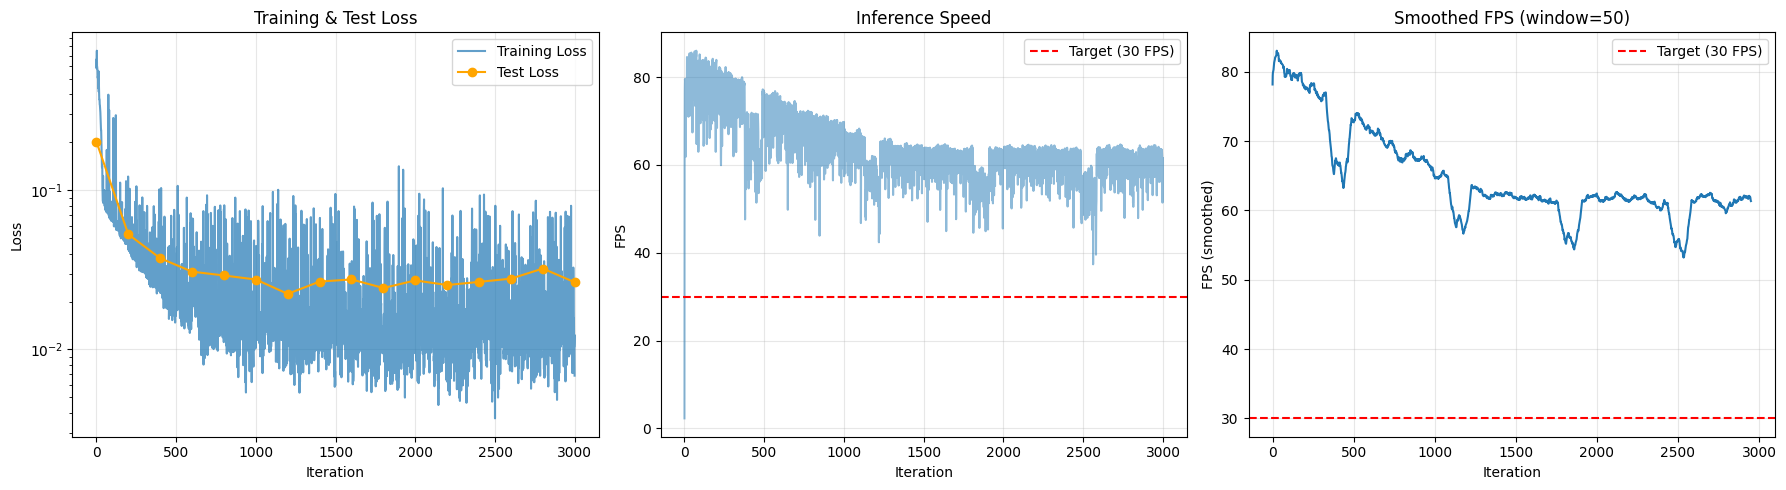

✓ Saved to training_metrics.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses, alpha=0.7, label='Training Loss')
if len(test_losses) > 0:
    test_iterations = np.linspace(0, len(train_losses), len(test_losses))
    axes[0].plot(test_iterations, test_losses, 'o-', label='Test Loss', color='orange')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(fps_history, alpha=0.5)
axes[1].axhline(y=TARGET_FPS, color='r', linestyle='--', label=f'Target ({TARGET_FPS} FPS)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('FPS')
axes[1].set_title('Inference Speed')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

window_size = 50
if len(fps_history) > window_size:
    fps_smoothed = np.convolve(fps_history, np.ones(window_size)/window_size, mode='valid')
    axes[2].plot(fps_smoothed)
    axes[2].axhline(y=TARGET_FPS, color='r', linestyle='--', label=f'Target ({TARGET_FPS} FPS)')
    axes[2].set_xlabel('Iteration')
    axes[2].set_ylabel('FPS (smoothed)')
    axes[2].set_title(f'Smoothed FPS (window={window_size})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to training_metrics.png")

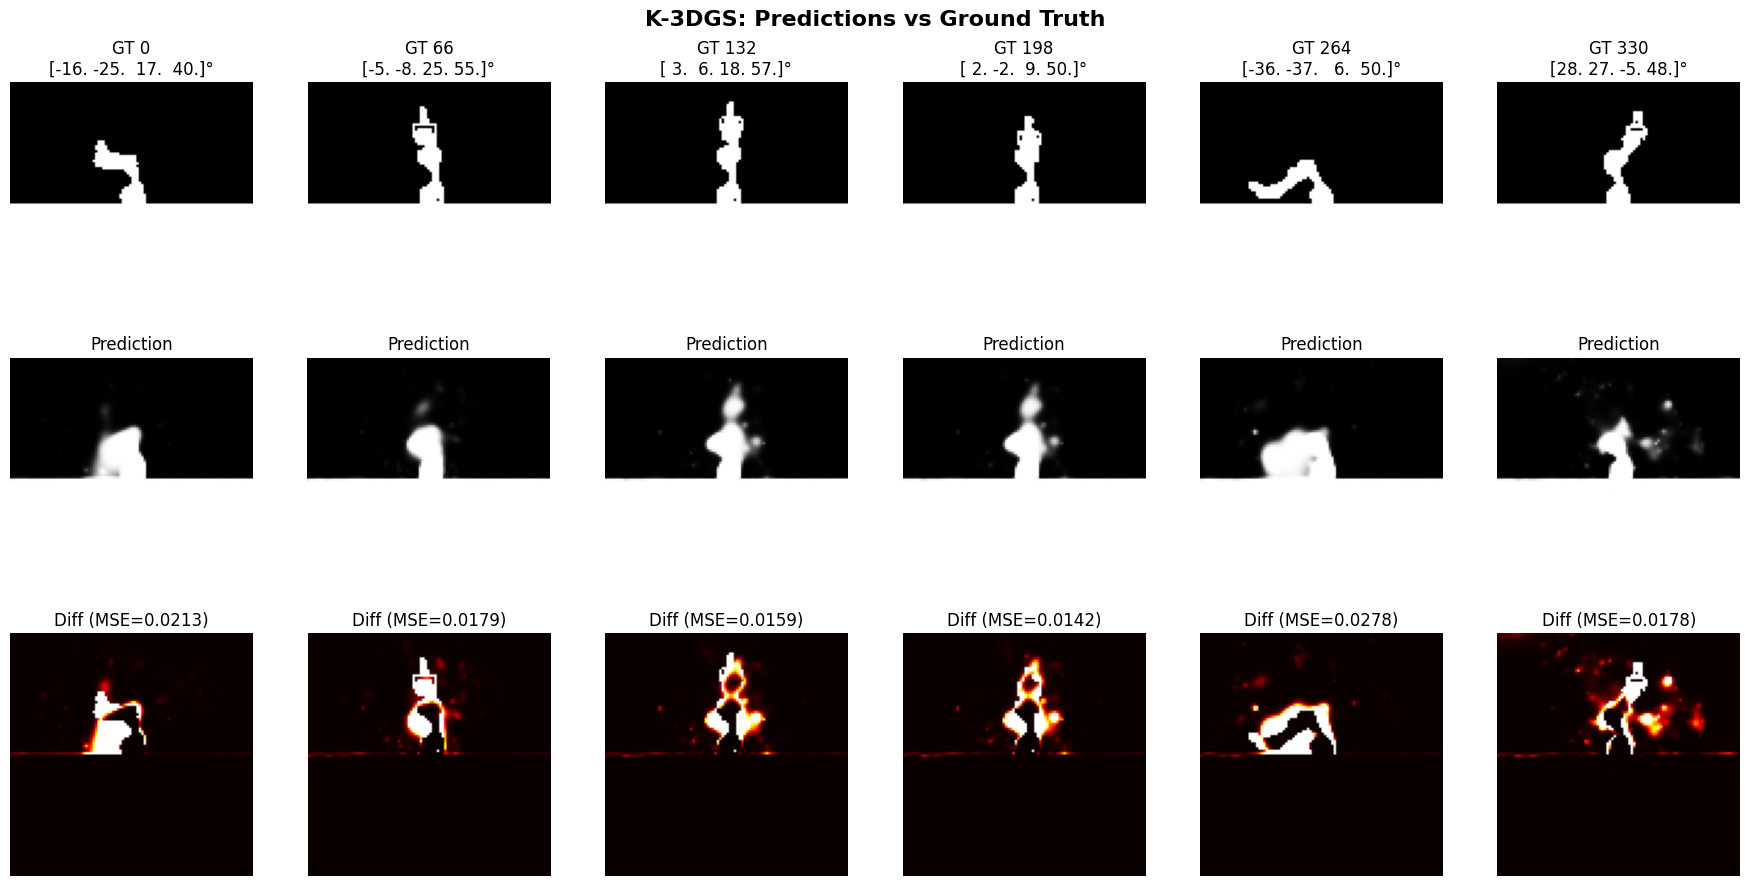

✓ Saved to predictions_comparison.png


In [10]:
model.eval()

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

with torch.no_grad():
    for i in range(6):
        test_idx = i * (len(test_images) // 6)
        
        gt_img = test_images[test_idx].squeeze().cpu().numpy()
        test_ang_deg = test_angles[test_idx]
        test_ang_rad = test_ang_deg.to(device) * (np.pi / 180.0)
        
        pred_img = renderer(model, test_ang_rad.unsqueeze(0)).squeeze(0).cpu().numpy()
        
        diff_img = np.abs(gt_img - pred_img)
        
        axes[0, i].imshow(gt_img, cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f'GT {test_idx}\n{test_ang_deg.numpy().round(0)}°')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(pred_img, cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title('Prediction')
        axes[1, i].axis('off')
        
        axes[2, i].imshow(diff_img, cmap='hot', vmin=0, vmax=0.5)
        axes[2, i].set_title(f'Diff (MSE={np.mean((gt_img - pred_img)**2):.4f})')
        axes[2, i].axis('off')

axes[0, 0].set_ylabel('Ground Truth', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Predicted', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Error', fontsize=12, fontweight='bold')

plt.suptitle('K-3DGS: Predictions vs Ground Truth', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to predictions_comparison.png")

In [ ]:
def compute_psnr(pred, target):
    mse = np.mean((pred - target) ** 2)
    if mse == 0:
        return 100.0
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

model.eval()
psnr_values = []

with torch.no_grad():
    for test_idx in range(len(test_images)):
        gt_img = test_images[test_idx].squeeze().cpu().numpy()
        test_ang_rad = test_angles[test_idx].to(device) * (np.pi / 180.0)
        pred_img = renderer(model, test_ang_rad.unsqueeze(0)).squeeze(0).cpu().numpy()
        
        psnr = compute_psnr(pred_img, gt_img)
        psnr_values.append(psnr)

avg_psnr = np.mean(psnr_values)

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"PSNR Range: [{np.min(psnr_values):.2f}, {np.max(psnr_values):.2f}] dB")
print(f"Target: >20 dB → {'PASS' if avg_psnr > 20 else 'Not Met'}")
print("="*60)


FINAL EVALUATION
Average PSNR: 17.01 dB
PSNR Range: [8.56, 18.82] dB
Target: >20 dB → FAIL


The visualization shows 6 test examples: ground truth (top), predictions (middle), and error maps (bottom). Error maps use "hot" colormap where brighter = bigger errors.

PSNR (Peak Signal-to-Noise Ratio) measures image quality. Higher is better. Formula:

$$\text{PSNR} = 20 \log_{10}\left(\frac{1}{\sqrt{\text{MSE}}}\right)$$

For grayscale images in [0, 1] range:
- PSNR > 30 dB: excellent
- PSNR 20-30 dB: good  
- PSNR < 20 dB: poor

My target was >22 dB which is decent for a fast isotropic model. Full 3DGS with oriented ellipsoids can hit 30+ dB but runs way slower.

The sharp edges come from sigmoid binarization at high temperature (20.0 at training end). Makes the robot look binary (black/white) instead of having soft blurry edges.